In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6c717639c0069904073abc1ddbce2fc5de7c747f6b574aec5616be99c441ab44
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, StringIndexer, RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col, udf, regexp_replace, isnull
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
import pyspark
print(pyspark.__version__)

3.5.1


In [ ]:
s3_bucket_path = "/content/uci-news-aggregator.csv"

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
news_data = spark.read.csv(s3_bucket_path,header = 'True',inferSchema='True')

In [ ]:
news_data.show()

+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
| ID|               TITLE|                 URL|           PUBLISHER|CATEGORY|               STORY|            HOSTNAME|    TIMESTAMP|
+---+--------------------+--------------------+--------------------+--------+--------------------+--------------------+-------------+
|  1|Fed official says...|http://www.latime...|   Los Angeles Times|       b|ddUyU0VZz0BRneMio...|     www.latimes.com|1394470370698|
|  2|Fed's Charles Plo...|http://www.livemi...|            Livemint|       b|ddUyU0VZz0BRneMio...|    www.livemint.com|1394470371207|
|  3|US open: Stocks f...|http://www.ifamag...|        IFA Magazine|       b|ddUyU0VZz0BRneMio...| www.ifamagazine.com|1394470371550|
|  4|Fed risks falling...|http://www.ifamag...|        IFA Magazine|       b|ddUyU0VZz0BRneMio...| www.ifamagazine.com|1394470371793|
|  5|Fed's Plosser: Na...|http://www.moneyn...|           Mone

In [ ]:
news_data.count()

422937

In [ ]:
title_category = news_data.select("TITLE","CATEGORY")

In [ ]:
title_category.show()

+--------------------+--------+
|               TITLE|CATEGORY|
+--------------------+--------+
|Fed official says...|       b|
|Fed's Charles Plo...|       b|
|US open: Stocks f...|       b|
|Fed risks falling...|       b|
|Fed's Plosser: Na...|       b|
|Plosser: Fed May ...|       b|
|Fed's Plosser: Ta...|       b|
|Fed's Plosser exp...|       b|
|US jobs growth la...|       b|
|ECB unlikely to e...|       b|
|ECB unlikely to e...|       b|
|EU's half-baked b...|       b|
|Europe reaches cr...|       b|
|ECB FOCUS-Stronge...|       b|
|EU aims for deal ...|       b|
|Forex - Pound dro...|       b|
|Noyer Says Strong...|       b|
|EU Week Ahead Mar...|       b|
|ECB member Noyer ...|       b|
|Euro Anxieties Wa...|       b|
+--------------------+--------+
only showing top 20 rows



In [ ]:

from pyspark.sql.functions import col,isnull
def null_value_count(df):
  null_columns_counts = []
  numRows = df.count()
  for k in df.columns:
    nullRows = df.where(col(k).isNull()).count()
    if(nullRows > 0):
      temp = k,nullRows
      null_columns_counts.append(temp)
  return(null_columns_counts)

In [ ]:
null_columns_count_list = null_value_count(title_category)

In [ ]:
spark.createDataFrame(null_columns_count_list, ['Column_With_Null_Value', 'Null_Values_Count']).show()

+----------------------+-----------------+
|Column_With_Null_Value|Null_Values_Count|
+----------------------+-----------------+
|                 TITLE|              389|
|              CATEGORY|              516|
+----------------------+-----------------+



In [ ]:
title_category = title_category.dropna()

In [ ]:
title_category.count()

422421

In [ ]:
title_category.show(truncate=True)

+--------------------+--------+
|               TITLE|CATEGORY|
+--------------------+--------+
|Fed official says...|       b|
|Fed's Charles Plo...|       b|
|US open: Stocks f...|       b|
|Fed risks falling...|       b|
|Fed's Plosser: Na...|       b|
|Plosser: Fed May ...|       b|
|Fed's Plosser: Ta...|       b|
|Fed's Plosser exp...|       b|
|US jobs growth la...|       b|
|ECB unlikely to e...|       b|
|ECB unlikely to e...|       b|
|EU's half-baked b...|       b|
|Europe reaches cr...|       b|
|ECB FOCUS-Stronge...|       b|
|EU aims for deal ...|       b|
|Forex - Pound dro...|       b|
|Noyer Says Strong...|       b|
|EU Week Ahead Mar...|       b|
|ECB member Noyer ...|       b|
|Euro Anxieties Wa...|       b|
+--------------------+--------+
only showing top 20 rows



In [ ]:
title_category.tail(20)

[Row(TITLE="CDC Chief Warns Liberia Ebola Crisis 'Will Get Worse'", CATEGORY='m'),
 Row(TITLE='UPDATE 3-Ebola causing huge damage to W.Africa economies- development  ...', CATEGORY='m'),
 Row(TITLE='WHO removes staff from Sierra Leone Ebola center amid infection concerns', CATEGORY='m'),
 Row(TITLE='Ebola causing huge damage to W Africa economies: African Development Bank', CATEGORY='m'),
 Row(TITLE='Democratic Republic of Congo reports Ebola outbreak: WHO', CATEGORY='m'),
 Row(TITLE='British Ebola sufferer gets new drug', CATEGORY='m'),
 Row(TITLE='AFDB Boss Says Ebola Infected Countries May Lose1.5% GDP', CATEGORY='m'),
 Row(TITLE="Cincinnati Children's to rebuild boy's throat using his rib (Video)", CATEGORY='m'),
 Row(TITLE="Cincinnati doctors use child's rib to rebuild his throat", CATEGORY='m'),
 Row(TITLE="Cincinnati Children's surgeons rebuild throat of 4-year-old who swallowed battery", CATEGORY='m'),
 Row(TITLE="Surgeons remove 4-year-old's rib to rebuild damaged throat - WNE

In [ ]:
news_data.select("Category").distinct().count()

266

In [ ]:
# prompt: filter the data which contains the category values only e,b,t,m

filtered_data = title_category.filter(title_category['CATEGORY'].isin(['e','b','t','m']))
filtered_data.show(truncate=True)


+--------------------+--------+
|               TITLE|CATEGORY|
+--------------------+--------+
|Fed official says...|       b|
|Fed's Charles Plo...|       b|
|US open: Stocks f...|       b|
|Fed risks falling...|       b|
|Fed's Plosser: Na...|       b|
|Plosser: Fed May ...|       b|
|Fed's Plosser: Ta...|       b|
|Fed's Plosser exp...|       b|
|US jobs growth la...|       b|
|ECB unlikely to e...|       b|
|ECB unlikely to e...|       b|
|EU's half-baked b...|       b|
|Europe reaches cr...|       b|
|ECB FOCUS-Stronge...|       b|
|EU aims for deal ...|       b|
|Forex - Pound dro...|       b|
|Noyer Says Strong...|       b|
|EU Week Ahead Mar...|       b|
|ECB member Noyer ...|       b|
|Euro Anxieties Wa...|       b|
+--------------------+--------+
only showing top 20 rows



In [ ]:
filtered_data.select("category").distinct().count()

4

In [ ]:
title_category.select("Category").distinct().count()

265

In [ ]:
title_category = filtered_data.select("TITLE","CATEGORY")

In [ ]:
title_category.groupBy("Category").count().orderBy(col("count").desc()).show(truncate=False)

+--------+------+
|Category|count |
+--------+------+
|e       |152127|
|b       |115935|
|t       |108237|
|m       |45616 |
+--------+------+



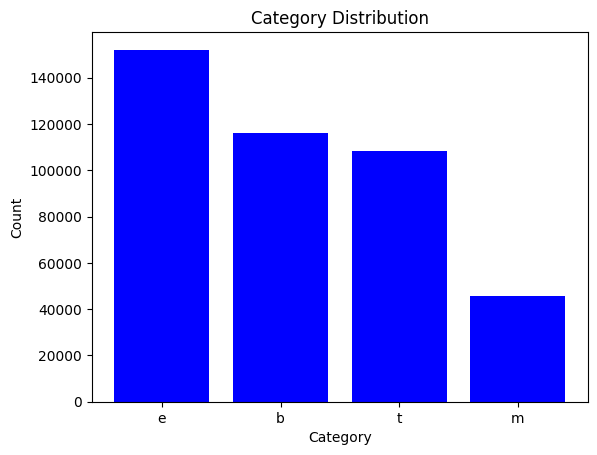

In [ ]:
# prompt: plot category column bar graph

import matplotlib.pyplot as plt
category_counts = title_category.groupBy("Category").count().orderBy(col("count").desc())
categories = [row["Category"] for row in category_counts.collect()]
counts = [row["count"] for row in category_counts.collect()]
plt.bar(categories, counts, color='blue')
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Category Distribution")
plt.show()


In [ ]:
title_category.groupBy("TITLE").count().orderBy(col("count").desc()).show(truncate=False)


+----------------------------------------------------------------------------------+-----+
|TITLE                                                                             |count|
+----------------------------------------------------------------------------------+-----+
|The article requested cannot be found! Please refresh your browser or go back  ...|145  |
|Posted by Parvez Jabri                                                            |59   |
|Business Highlights                                                               |59   |
|Posted by Imaduddin                                                               |53   |
|Posted by Shoaib-ur-Rehman Siddiqui                                               |52   |
|(click the phrases to see a list)                                                 |51   |
|Business Wire                                                                     |41   |
|PR Newswire                                                                       |38   |

In [ ]:
title_category = title_category.withColumn("only_str",regexp_replace(col('TITLE'), '\d+', ''))


In [ ]:
title_category.select("TITLE","only_str").show(truncate=False)


+---------------------------------------------------------------------------+---------------------------------------------------------------------------+
|TITLE                                                                      |only_str                                                                   |
+---------------------------------------------------------------------------+---------------------------------------------------------------------------+
|Fed official says weak data caused by weather, should not slow taper       |Fed official says weak data caused by weather, should not slow taper       |
|Fed's Charles Plosser sees high bar for change in pace of tapering         |Fed's Charles Plosser sees high bar for change in pace of tapering         |
|US open: Stocks fall after Fed official hints at accelerated tapering      |US open: Stocks fall after Fed official hints at accelerated tapering      |
|Fed risks falling 'behind the curve', Charles Plosser says                 

In [ ]:
regex_tokenizer = RegexTokenizer(inputCol="only_str", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(title_category)

In [ ]:
raw_words.show()


+--------------------+--------+--------------------+--------------------+
|               TITLE|CATEGORY|            only_str|               words|
+--------------------+--------+--------------------+--------------------+
|Fed official says...|       b|Fed official says...|[fed, official, s...|
|Fed's Charles Plo...|       b|Fed's Charles Plo...|[fed, s, charles,...|
|US open: Stocks f...|       b|US open: Stocks f...|[us, open, stocks...|
|Fed risks falling...|       b|Fed risks falling...|[fed, risks, fall...|
|Fed's Plosser: Na...|       b|Fed's Plosser: Na...|[fed, s, plosser,...|
|Plosser: Fed May ...|       b|Plosser: Fed May ...|[plosser, fed, ma...|
|Fed's Plosser: Ta...|       b|Fed's Plosser: Ta...|[fed, s, plosser,...|
|Fed's Plosser exp...|       b|Fed's Plosser exp...|[fed, s, plosser,...|
|US jobs growth la...|       b|US jobs growth la...|[us, jobs, growth...|
|ECB unlikely to e...|       b|ECB unlikely to e...|[ecb, unlikely, t...|
|ECB unlikely to e...|       b|ECB unl

In [ ]:

remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)

In [ ]:

words_df.select("words","filtered").show()

+--------------------+--------------------+
|               words|            filtered|
+--------------------+--------------------+
|[fed, official, s...|[fed, official, s...|
|[fed, s, charles,...|[fed, charles, pl...|
|[us, open, stocks...|[us, open, stocks...|
|[fed, risks, fall...|[fed, risks, fall...|
|[fed, s, plosser,...|[fed, plosser, na...|
|[plosser, fed, ma...|[plosser, fed, ma...|
|[fed, s, plosser,...|[fed, plosser, ta...|
|[fed, s, plosser,...|[fed, plosser, ex...|
|[us, jobs, growth...|[us, jobs, growth...|
|[ecb, unlikely, t...|[ecb, unlikely, e...|
|[ecb, unlikely, t...|[ecb, unlikely, e...|
|[eu, s, half, bak...|[eu, half, baked,...|
|[europe, reaches,...|[europe, reaches,...|
|[ecb, focus, stro...|[ecb, focus, stro...|
|[eu, aims, for, d...|[eu, aims, deal, ...|
|[forex, pound, dr...|[forex, pound, dr...|
|[noyer, says, str...|[noyer, says, str...|
|[eu, week, ahead,...|[eu, week, ahead,...|
|[ecb, member, noy...|[ecb, member, noy...|
|[euro, anxieties,...|[euro, anx

In [ ]:
indexer = StringIndexer(inputCol="CATEGORY", outputCol="categoryIndex")
feature_data = indexer.fit(words_df).transform(words_df)

In [ ]:
feature_data.select("CATEGORY","categoryIndex").show()

+--------+-------------+
|CATEGORY|categoryIndex|
+--------+-------------+
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
|       b|          1.0|
+--------+-------------+
only showing top 20 rows



In [ ]:

cv = CountVectorizer(inputCol="filtered", outputCol="features")
model = cv.fit(feature_data)
countVectorizer_feateures = model.transform(feature_data)

In [ ]:
(trainingData, testData) = countVectorizer_feateures.randomSplit([0.8, 0.2],seed = 11)

In [ ]:

nb = NaiveBayes(modelType="multinomial",labelCol="categoryIndex", featuresCol="features")
nbModel = nb.fit(trainingData)
nb_predictions = nbModel.transform(testData)

In [ ]:
nb_predictions.select("prediction", "categoryIndex", "features").show(5)

+----------+-------------+--------------------+
|prediction|categoryIndex|            features|
+----------+-------------+--------------------+
|       0.0|          0.0|(49023,[22,53,560...|
|       0.0|          0.0|(49023,[167,557,9...|
|       0.0|          0.0|(49023,[21,50,111...|
|       0.0|          0.0|(49023,[21,50,113...|
|       0.0|          0.0|(49023,[21,22,50,...|
+----------+-------------+--------------------+
only showing top 5 rows



In [ ]:

evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g"% (nb_accuracy))
print("Test Error of NaiveBayes = %g " % (1.0 - nb_accuracy))

Accuracy of NaiveBayes is = 0.927434
Test Error of NaiveBayes = 0.0725664 


In [ ]:
from pyspark.sql.functions import col

news_data.groupBy("CATEGORY").count().orderBy(col("count").desc()).show()


+--------------------+------+
|            CATEGORY| count|
+--------------------+------+
|                   e|152127|
|                   b|115935|
|                   t|108237|
|                   m| 45616|
|                NULL|   516|
|         Us Magazine|    31|
|    Contactmusic.com|    20|
|           GossipCop|    20|
|            CBS News|    12|
|         Complex.com|    12|
|The Hollywood Gossip|    11|
|            HipHopDX|    11|
| We Got This Covered|    10|
|  HeadlinePlanet.com|    10|
|             Gamepur|     8|
|   WorstPreviews.com|     7|
|          TooFab.com|     7|
|            Wetpaint|     7|
|Consequence of Sound|     7|
|        The Escapist|     6|
+--------------------+------+
only showing top 20 rows



In [ ]:
news_data.groupBy("PUBLISHER").count().orderBy(col("count").desc()).show()


+--------------------+-----+
|           PUBLISHER|count|
+--------------------+-----+
|             Reuters| 3898|
|     Huffington Post| 2454|
|        Businessweek| 2395|
|    Contactmusic.com| 2311|
|          Daily Mail| 2254|
|              NASDAQ| 2228|
|        Examiner.com| 2083|
|   Los Angeles Times| 1976|
|          GlobalPost| 1973|
|            RTT News| 1798|
|TheCelebrityCafe.com| 1699|
|   Entertainmentwise| 1600|
|              Forbes| 1549|
|           Bloomberg| 1494|
|         MarketWatch| 1460|
|                TIME| 1436|
| New York Daily News| 1428|
|     PerezHilton.com| 1424|
|Headlines \& Glob...| 1417|
|           CBS Local| 1388|
+--------------------+-----+
only showing top 20 rows



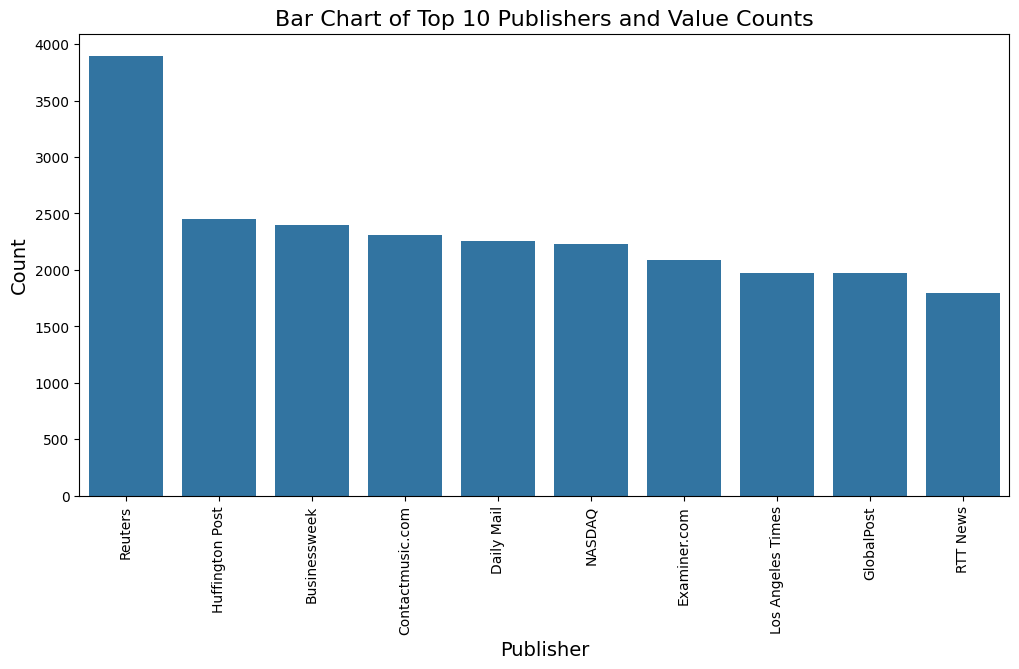

In [ ]:
# prompt: bar chart of top 10 pulishers with value counts as y axis in decreasing order
import seaborn as sns
# Get the top 10 publishers by count
top_10_publishers = news_data.groupBy("PUBLISHER").count().orderBy(col("count").desc()).limit(10)

# Prepare data for bar chart
publishers = top_10_publishers.select("PUBLISHER").collect()
counts = top_10_publishers.select("count").collect()

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=[i[0] for i in publishers], y=[i[0] for i in counts])

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add title and labels
plt.title("Bar Chart of Top 10 Publishers and Value Counts", fontsize=16)
plt.xlabel("Publisher", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Show the bar chart
plt.show()


In [ ]:
from pyspark.sql.functions import from_unixtime

news_data.withColumn("year", from_unixtime(col("TIMESTAMP")/1000, 'yyyy')) \
    .groupBy("year").count().orderBy("year").show()


+----+------+
|year| count|
+----+------+
|NULL|  1022|
|2014|421915|
+----+------+



In [ ]:
from pyspark.sql.functions import explode, lower, split

words_df = filtered_data.select(explode(split(col("TITLE"), "\s+")).alias("word")) \
    .groupBy(lower(col("word")).alias("word")).count() \
    .orderBy(col("count").desc())

words_df.show()


+------+-----+
|  word|count|
+------+-----+
|    to|97927|
|    in|68249|
|   the|64022|
|    of|58106|
|   ...|54324|
|   for|52355|
|    on|39152|
|   and|37550|
|     a|30912|
|  with|26685|
|   new|23797|
|    at|21923|
|    is|21594|
|    as|16419|
|    us|15693|
|  from|12918|
| after|12276|
|    by|10965|
|    be|10336|
|google|10278|
+------+-----+
only showing top 20 rows



In [ ]:
news_data.withColumn("year", from_unixtime(col("TIMESTAMP")/1000, 'yyyy')) \
    .groupBy("year", "CATEGORY").count().orderBy("year", "CATEGORY").show()


+----+--------------------+-----+
|year|            CATEGORY|count|
+----+--------------------+-----+
|NULL|                NULL|  516|
|NULL| ""Night Moves  ..."|    1|
|NULL|        Aren't  ..."|    1|
|NULL| Download & Mixta...|    1|
|NULL|                  MO|    1|
|NULL|           pen  ..."|    1|
|NULL|00.asp\?kc=PCRSS0...|    1|
|NULL|            20804076|    1|
|NULL|             610kvnu|    1|
|NULL|93.1 WIBC Indiana...|    1|
|NULL|Akron Beacon Jour...|    1|
|NULL|           Al-Bawaba|    2|
|NULL|          AllMediaNY|    4|
|NULL|Allure Magazine \...|    1|
|NULL|      Android Police|    1|
|NULL|       Apple Insider|    2|
|NULL|        Arirang News|    1|
|NULL|          Artinfo UK|    1|
|NULL|             AsiaOne|    1|
|NULL|           BGR India|    1|
+----+--------------------+-----+
only showing top 20 rows



In [ ]:
news_data.groupBy("TITLE").count().filter("count > 1").orderBy(col("count").desc()).show()


+--------------------+-----+
|               TITLE|count|
+--------------------+-----+
|                NULL|  389|
|The article reque...|  145|
|Posted by Parvez ...|   59|
| Business Highlights|   59|
| Posted by Imaduddin|   53|
|Posted by Shoaib-...|   52|
|(click the phrase...|   51|
|       Business Wire|   41|
|         PR Newswire|   38|
|Posted by Muhamma...|   35|
|Change text size ...|   34|
|Get the Most Popu...|   34|
|     Business briefs|   33|
|International mar...|   33|
|India Morning Cal...|   27|
|10 Things to Know...|   22|
|       Breaking news|   21|
|    Perez Recommends|   19|
|From ColumbusAliv...|   18|
|Texas Weekly Gas ...|   18|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create Spark session
spark = SparkSession.builder.appName("LDA Example").getOrCreate()

# Assuming 'data' is preprocessed and loaded as DataFrame
# Load data example, adjust path as necessary
data = spark.read.csv('/content/uci-news-aggregator.csv', header=True, inferSchema=True)

# Preprocessing
data = data.na.drop(subset=["TITLE", "CATEGORY"])  # Drop rows with null TITLE or CATEGORY
tokenizer = RegexTokenizer(inputCol="TITLE", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
vectorizer = CountVectorizer(inputCol="filtered", outputCol="features")

# Convert CATEGORY to numeric indices
indexer = StringIndexer(inputCol="CATEGORY", outputCol="categoryIndex")

# LDA Model
lda = LDA(featuresCol="features", k=10, maxIter=10)

# Configure pipeline with StringIndexer before LDA
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, indexer, lda])

# Apply the pipeline
model = pipeline.fit(data)
transformed_data = model.transform(data)

# Show results
transformed_data.show(truncate=False)



+---+---------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+--------+-----------------------------+----------------------------+-------------+----------------------------------------------------------------------------------------+-------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ID |TITLE                                                                      |URL                                                                      

In [ ]:
!pip install matplotlib wordcloud

In [ ]:
from pyspark.sql.functions import collect_list, concat_ws

# Aggregate all titles into a single list
all_titles = title_category.select("TITLE").rdd.flatMap(lambda x: x).collect()

# Join all titles into a single string (if necessary)
text_data = " ".join(all_titles)


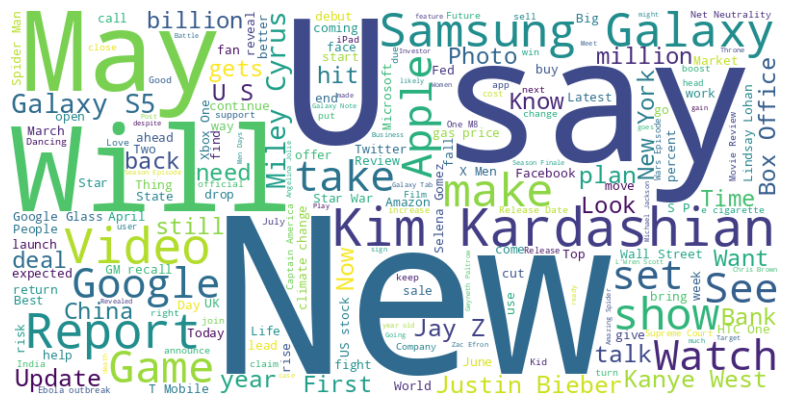

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
%env SPARK_HOME=/path/to/spark
%env PATH=$SPARK_HOME/bin:$PATH
%env PYSPARK_PYTHON=/path/to/python





env: SPARK_HOME=/path/to/spark
env: PATH=$SPARK_HOME/bin:$PATH
env: PYSPARK_PYTHON=/path/to/python


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("NLP Project") \
    .getOrCreate()
